## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log
import skimage
import random
import tensorflow as tf



from visualize import display_images

from skimage.morphology import label # label regions

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_dsbowl_0021.h5")

from visualize import display_images
#matplotlib inline
FloydHub=1
# Root directory of the project
ROOT_DIR = os.getcwd()

if(FloydHub):
    dataDir="/input/"
    ModelLib="/model"
else:
    ModelLib=ROOT_DIR
# Directory to save logs and trained model
MODEL_DIR = os.path.join("/output", "logs")
#MODEL_DIR = os.path.join("/input", "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ModelLib, "mask_rcnn_dsbowl_0019.h5")

/Users/Ravi/anaconda/envs/DLN/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
import pandas as pd
df=pd.read_csv("../../classes.csv")
df.head()
df["dataset"]="data"
dataset_dir_list=["../DSB2018/train/", "../DSB2018/valdata/","../DSB2018_test/stage1_test/"]
subset=["train", "valdata","test"]
for ii in range(3):
    dataset_dir=dataset_dir_list[ii]
    image_ids = [ filename  for filename in os.listdir(dataset_dir) \
                     if os.path.isdir(dataset_dir+filename+"/images") ]
    for image_id in image_ids:
        #print(image_id,df[df["filename"]==image_id+".png"])
        df.loc[df["filename"]==image_id+".png","dataset"]=subset[ii]
df.to_csv("../classes_sorted.csv")
    

In [52]:
df=pd.read_csv("classes_sorted.csv")
subset="train"
df2=df[(df["dataset"]==subset) & (df["Type"]==1)]
filenames=df2["filename"].values
print(filenames)

['d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1173f5150dde8ff38cf.png'
 '4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0.png'
 'b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39ff843884d84f61dee1.png'
 '831218e6a1a54b23d4be56c5799854e7eb978811b89215319dc138900bd563e6.png'
 'b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845bdc01b2b3ee2299229.png'
 '4a424e0cb845cf6fd4d9fe62875552c7b89a4e0276cf16ebf46babe4656a794e.png'
 '43cf6b2ec0b0745ac2b87b4d8780f62e9050d3f5d50a1fcefa42d166191e84c6.png'
 'f487cc82271cf84b4414552aa8b0a9d82d902451ebe8e8bc639d4121c1672ff7.png'
 'bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da1a2d96df73782b6.png'
 'b2c23ddb04531158da6a0abcaca78fec0ae5c6f64f60166e4f36f4a161efd76f.png'
 '72e8c49dea44787114fd191f9e97e260f961c6e7ae4715bc95cc91db8d91a4e3.png'
 'e321cfa987e77c21373a0f8b1236c83d6636306949a82a7f5b07fc0838e7777f.png'
 '80632d6be60c8462e50d51bcf5caf15308931603095d6b5e772a115cd0d0470c.png'
 '6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee56

In [126]:
class DSBowlConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "dsbowl"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU =4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640

    MAX_GT_INSTANCES=256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4,8, 16, 32, 64)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 256

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 300

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    USE_MINI_MASK=False
    MINI_MASK_SHAPE = (128, 128)


class DSBowlDataset(utils.Dataset):
    def load_DSBowldataset(self, dataset_dir,subset,TypeImage):
        # Add classes using add_class function
        ##create subset for validation
        self.add_class("dsbowl", 1, "nucleus")

        df=pd.read_csv("classes_sorted.csv")
        df2=df[(df["dataset"]==subset) & (df["Type"]==TypeImage)]
        image_ids=df2["filename"].values
        # Add images using add_class function
        for i in image_ids:
            filename=i[:-4]
            masks=[dataset_dir+filename+"/masks/"+mask for mask in os.listdir(dataset_dir+filename+"/masks") if ".png" in mask]
            #masks=[]
            image = skimage.io.imread(dataset_dir+filename+"/images/"+filename+".png")
            self.add_image("dsbowl", image_id=filename,
                path=os.path.join(dataset_dir+filename,"images",filename+".png"),
                width=image.shape[0],
                height=image.shape[1],
                annotations=masks)

    def load_image(self, image_id):
        """Sample implementation as super-class
           TODO: possibly Modify implementation to pre-process images to Mask-RCNN
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        if image.shape[-1]== 4:
            image = skimage.color.rgba2rgb(image,[1,1,1])*255
        #image1 = skimage.color.rgb2gray(image)
        #print(np.mean(image1[:,:]))
        log("gray image",image)
        image=image*(255/np.max(image))
        image=np.where(image>20,image,0)
        image=image-[128,128,128]
        #image=skimage.color.gray2rgb(image1)
        #mean_val=np.array([np.mean(image[:,:,0]), np.mean(image[:,:,1]),np.mean(image[:,:,2])])
        #image=image-mean_val
        return image

    def image_reference(self, image_id):
        """Return the DSbowl data path of the image.
            Add additional sources as required"""
        info = self.image_info[image_id]
        if info["source"] == "dsbowl":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Load instance masks for the given image

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance. Binary masks
        class_ids: a 1D array of class IDs of the instance masks.
        """
        annotations = self.image_info[image_id]["annotations"]
        masks=[skimage.io.imread(mask) for mask in annotations]
        # Build mask of shape [height, width, instance_count] and list
        masks=np.array(masks)
        #print(np.argwhere(masks>1))
        #print(np.moveaxis(masks,0,-1).shape)
        mask=np.moveaxis(masks,0,-1)>1
        # list of class IDs that correspond to each channel of the mask.
        Nmasks=mask.shape[-1]
        class_ids=np.ones(Nmasks,dtype=np.int32)
        return mask, class_ids


config = DSBowlConfig()
config.display()




Configurations:
BACKBONE_SHAPES                [[160 160]
 [ 80  80]
 [ 40  40]
 [ 20  20]
 [ 10  10]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        1000
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 4
IMAGE_MAX_DIM                  640
IMAGE_MIN_DIM                  640
IMAGE_PADDING                  True
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [56, 56]
MAX_GT_INSTANCES               256
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (128, 128)
NAME                           dsbowl
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING     

In [92]:
# Training dataset
#dataset_dir="/input/stage1_test/"

dataset_dir="../DSB2018/train/"
dataset_test = DSBowlDataset()
dataset_test.load_DSBowldataset(dataset_dir,"train",1)
dataset_test.prepare()



## Configurations

In [72]:
image, image_meta, class_ids, bbox, mask=modellib.load_image_gt(dataset_test, config, 65, augment=False,
                  use_mini_mask=False)
class_ids

(256, 256, 3)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [18]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[160 160]
 [ 80  80]
 [ 40  40]
 [ 20  20]
 [ 10  10]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        1000
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  640
IMAGE_MIN_DIM                  640
IMAGE_PADDING                  True
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [56, 56]
MAX_GT_INSTANCES               256
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (128, 128)
NAME                           dsbowl
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING     

In [24]:
def load_image_gt(dataset, config, image_id, augment=False,
                  use_mini_mask=False):
    """Load and return ground truth data for an image (image, mask, bounding boxes).

    augment: If true, apply random image augmentation. Currently, only
        horizontal flipping is offered.
    use_mini_mask: If False, returns full-size masks that are the same height
        and width as the original image. These can be big, for example
        1024x1024x100 (for 100 instances). Mini masks are smaller, typically,
        224x224 and are generated by extracting the bounding box of the
        object and resizing it to MINI_MASK_SHAPE.

    Returns:
    image: [height, width, 3]
    shape: the original shape of the image before resizing and cropping.
    class_ids: [instance_count] Integer class IDs
    bbox: [instance_count, (y1, x1, y2, x2)]
    mask: [height, width, instance_count]. The height and width are those
        of the image unless use_mini_mask is True, in which case they are
        defined in MINI_MASK_SHAPE.
    """
    # Load image and mask

    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    if augment:
        rot_angle=np.random.random_sample()*10
        image= skimage.transform.rotate(image,rot_angle,resize=True)
        mask= skimage.transform.rotate(mask,rot_angle, resize=True)
    #print(mask)
    log("mask", mask)
    shape = image.shape
    log("image", image)
    image, window, scale, padding = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        max_dim=config.IMAGE_MAX_DIM,
        padding=config.IMAGE_PADDING)
    log("image", image)
    mask = utils.resize_mask(mask, scale, padding)

    # Random horizontal flips.
    if augment:
        if random.randint(0, 1):
            image = np.fliplr(image)
            mask = np.fliplr(mask)

    # Bounding boxes. Note that some boxes might be all zeros
    # if the corresponding mask got cropped out.
    # bbox: [num_instances, (y1, x1, y2, x2)]
    bbox = utils.extract_bboxes(mask)

    # Active classes
    # Different datasets have different classes, so track the
    # classes supported in the dataset of this image.
    active_class_ids = np.zeros([dataset.num_classes], dtype=np.int32)
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
    active_class_ids[source_class_ids] = 1

    # Resize masks to smaller size to reduce memory usage
    if use_mini_mask:
        mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)

    # Image meta data
    #image_meta = compose_image_meta(image_id, shape, window, active_class_ids)

    return image,  class_ids, bbox, mask


## Notebook Preferences

In [6]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [70]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [127]:
# Training dataset
#dataset_dir="/input/stage1_test/"

dataset_dir="../DSB2018/train/"
dataset_test = DSBowlDataset()
dataset_test.load_DSBowldataset(dataset_dir,"train",1)
dataset_test.prepare()
#dataset_test.image_ids

gray image               shape: (256, 256, 3)         min:    2.00000  max:  132.00000
../DSB2018/train/c3bec1066aae20f48b82975e7e8b684cd67635a8baf211e4d9e3e13bc54c5d06/images/c3bec1066aae20f48b82975e7e8b684cd67635a8baf211e4d9e3e13bc54c5d06.png
gray image               shape: (256, 256, 3)         min:    2.00000  max:  132.00000
origimage                shape: (256, 256, 3)         min: -128.00000  max:  127.00000


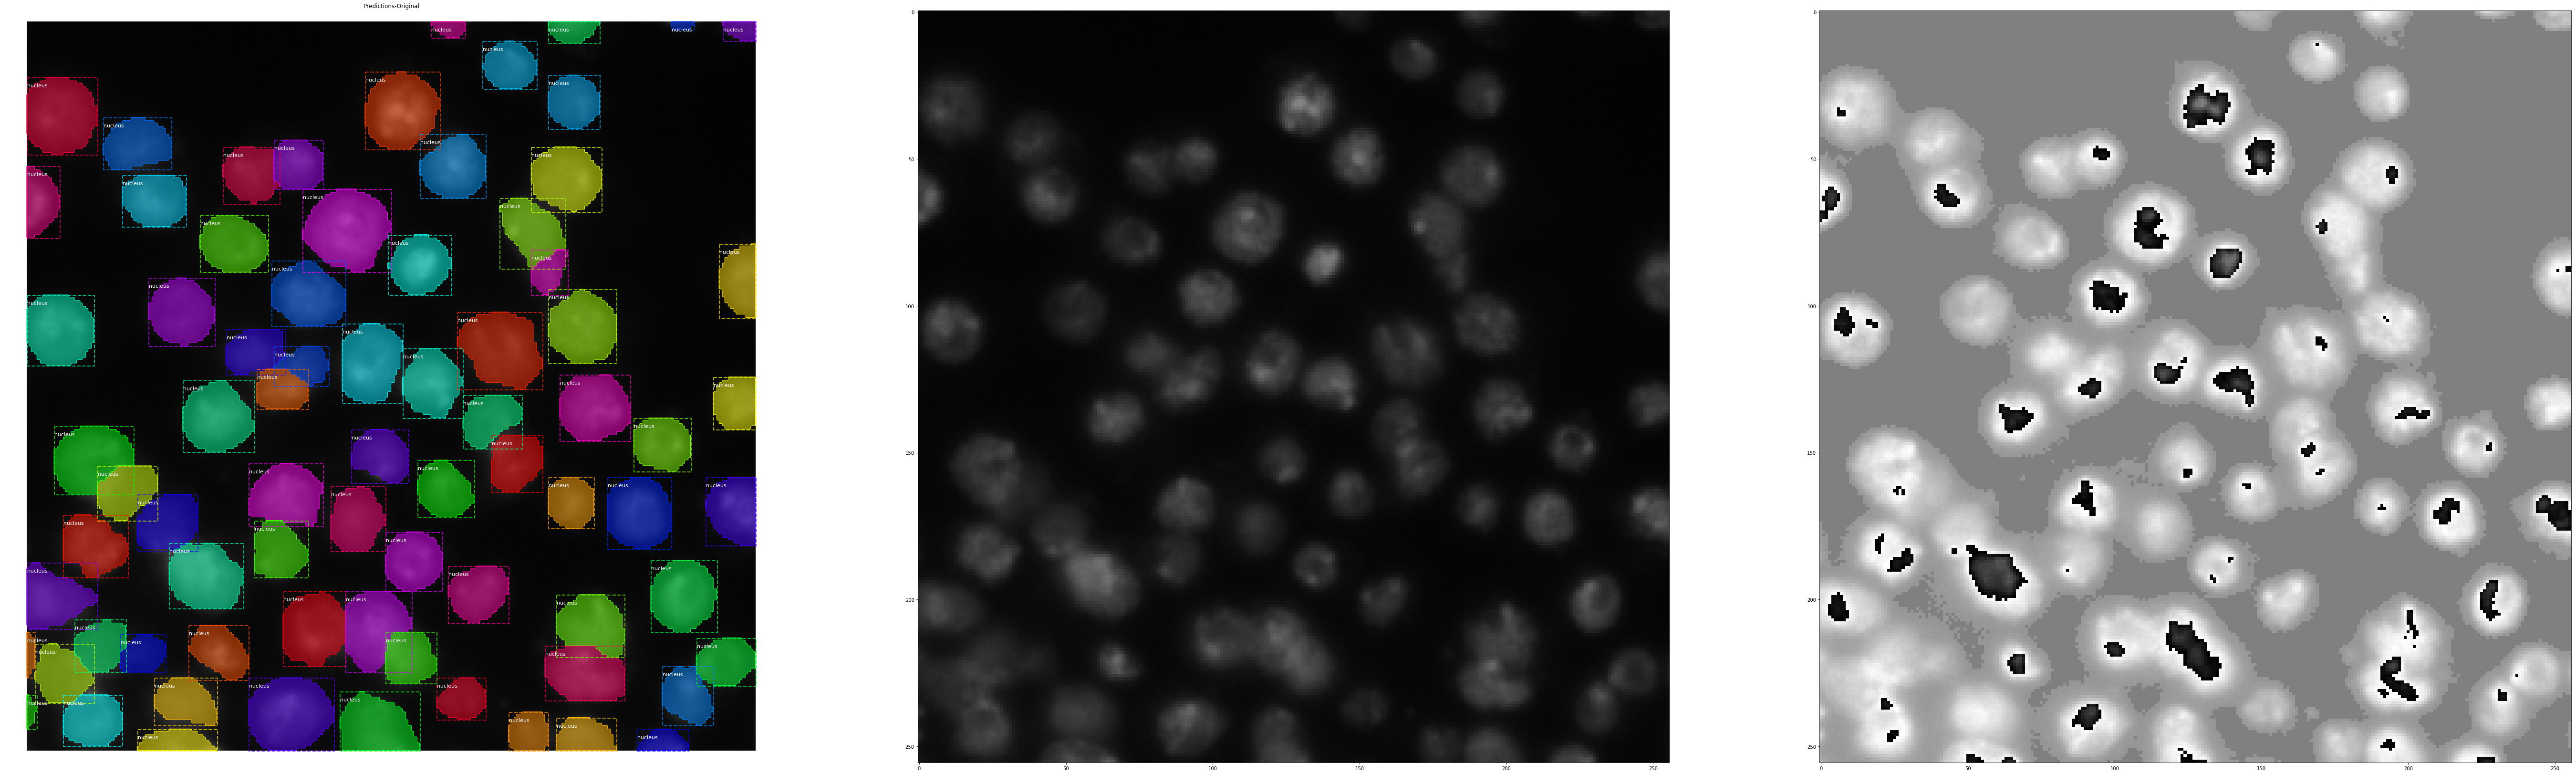

In [128]:
image_id=180
image, image_meta, class_ids, bbox, mask=modellib.load_image_gt(dataset_test, config, image_id, augment=False,
                  use_mini_mask=False)

print(dataset_test.image_info[image_id]['path'])
ax=get_ax(1,3,size=32)
origimage1 = skimage.io.imread(dataset_test.image_info[image_id]['path'])
image, window, scale, padding = utils.resize_image(origimage1,min_dim=config.IMAGE_MIN_DIM, 
                                                   max_dim=config.IMAGE_MAX_DIM, padding=config.IMAGE_PADDING)
origimage=dataset_test.load_image(image_id)
if origimage1.shape[-1]== 4:
    origimage1 = skimage.color.rgba2rgb(origimage1,[1,1,1])*255
log("origimage", origimage)
#origimage=np.rot90(origimage)
#origimage1=np.rot90(origimage1)
ax[2].imshow(origimage.astype(np.uint8))
ax[1].imshow(origimage1.astype(np.uint8))
#maskbbox=utils.extract_bboxes(masks_resized)
visualize.display_instances(image, bbox, mask, 
                            class_ids,{1:'nucleus'},scores=None, ax=ax[0],
                            title="Predictions-Original")

In [118]:
# Training dataset
#dataset_dir="/input/stage1_test/"
dataset_dir="../DSB2018_test/stage1_test/"
dataset_test = DSBowlDataset()
dataset_test.load_DSBowldataset(dataset_dir,"test")
dataset_test.prepare()


print("Images: {}\nClasses: {}".format(len(dataset_test.image_ids), dataset_test.class_names))

TypeError: load_DSBowldataset() missing 1 required positional argument: 'TypeImage'

## Load Model

In [10]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

COCO_MODEL_PATH = os.path.join(ModelLib, "mask_rcnn_dsbowl_0019.h5")
# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()[1]
#weights_path = COCO_MODEL_PATH
weights_path="../models/x640x640/mask_rcnn_dsbowl_0021.h5"
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  ../models/x640x640/mask_rcnn_dsbowl_0021.h5


In [12]:
import scipy.ndimage
def mask_resize_to_original(mask, window , scale,original_shape):
    """Resizes a mask back to original mask dimensions
        scale: mask scaling factor used earlier
        window: From the resized image function
    """
    mask=mask[window[0]:window[2],window[1]:window[3]]
    h, w = mask.shape[:2]
    if scale < 1 :
        #mask=scipy.ndimage.interpolation.zoom(mask,[1/scale,1/scale],order=0)
        mask = skimage.transform.resize(mask,original_shape)
    else:
        #mask=scipy.ndimage.interpolation.zoom(mask,[1/scale,1/scale],order=0)
        mask = skimage.transform.resize(mask,original_shape,order=0)
    if(mask.shape!=original_shape):
            mask = skimage.transform.resize(mask,original_shape,order=0)
    return mask

In [34]:
f=open("/output/output.csv","w")
f.write("ImageIDnumber,ImageId,EncodedPixels\n")
f.write(rleout_out)
f.close()

len(d)

65

In [28]:
rleout_out=""
d={}
for image_id in dataset_test.image_ids:
    rleout1,masks_resized_mod=model_eval(image_id)
    d[image_id]=masks_resized_mod
    rleout_out=rleout_out+rleout1

(519, 253, 3)


/usr/local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


image                    shape: (640, 640, 3)         min:  -11.86330  max:   78.78018
0 57
41 Overlapped-masks {41}
No of overlapped pixels 9 9
image-id 0 mask-overlap 0
(512, 680, 3)
image                    shape: (640, 640, 3)         min: -219.39334  max:   56.16960


/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1 23
Overlapped-masks set()
No of overlapped pixels 0 0
image-id 1 mask-overlap 0
(512, 680, 3)
image                    shape: (640, 640, 3)         min: -213.01793  max:   60.09858
2 39
Overlapped-masks set()
No of overlapped pixels 0 0
image-id 2 mask-overlap 0
(520, 348, 3)
image                    shape: (640, 640, 3)         min:  -27.49237  max:  155.65220
3 234
129 198 Overlapped-masks {129, 198}
No of overlapped pixels 14 14
image-id 3 mask-overlap 0
(256, 256, 3)
image                    shape: (640, 640, 3)         min:  -17.22729  max:  246.69258
4 48
26 39 Overlapped-masks {26, 39}
No of overlapped pixels 33 33
image-id 4 mask-overlap 0
(524, 348, 3)
image                    shape: (640, 640, 3)         min: -203.86633  max:   54.86126
5 126
70 Overlapped-masks {70}
No of overlapped pixels 11 11
image-id 5 mask-overlap 0
(256, 256, 3)
image                    shape: (640, 640, 3)         min:   -4.36758  max:  103.65662
6 13
Overlapped-masks set()
No of overlapped pixels 0

44 75
Overlapped-masks set()
No of overlapped pixels 0 0
image-id 44 mask-overlap 0
(520, 696, 3)
image                    shape: (640, 640, 3)         min:  -14.76526  max:  211.98316
45 35
Overlapped-masks set()
No of overlapped pixels 0 0
image-id 45 mask-overlap 0
(519, 161, 3)
image                    shape: (640, 640, 3)         min:  -30.75692  max:  229.89339
46 54
14 32 33 48 Overlapped-masks {48, 33, 32, 14}
No of overlapped pixels 314 314
image-id 46 mask-overlap 0
(256, 256, 3)
image                    shape: (640, 640, 3)         min:   -4.76901  max:  263.16376
47 15
6 Overlapped-masks {6}
No of overlapped pixels 2 2
image-id 47 mask-overlap 0
(524, 348, 3)
image                    shape: (640, 640, 3)         min: -224.19717  max:   42.71173
48 91
27 Overlapped-masks {27}
No of overlapped pixels 40 40
image-id 48 mask-overlap 0
(520, 696, 3)
image                    shape: (640, 640, 3)         min:   -8.16330  max:  201.70203
49 27
Overlapped-masks set()
No of overlappe

In [50]:
import sys
from contextlib import redirect_stdout
#image_id=35
def same_pixel_func(masks_resized):
    masks_resized_mod=np.zeros(masks_resized.shape,dtype=np.uint8)
    count=0
    for ii in range(masks_resized.shape[-1]): 
        mask1=masks_resized[:,:,ii]
        for jj in range(ii+1,masks_resized.shape[-1]):
            #print(ii,jj,end=" ")
            mask2=masks_resized[:,:,jj]
            same_pixel=np.multiply(mask1,mask2)
            #log("same pixel", same_pixel)
            same_pixel_index=np.argwhere(same_pixel==1)
            mask1 = np.where(same_pixel==1,0, mask1)
            if(len(same_pixel_index)>0):
                print(ii, end=" ")
                count=count+len(same_pixel_index)
        masks_resized_mod[:,:,ii]=mask1
    print("Overlapped-masks",set(np.where(masks_resized_mod!=masks_resized)[2]))
    print("No of overlapped pixels", count,len(np.where(masks_resized_mod!=masks_resized)[2]))
    return masks_resized_mod

def same_pixel_func_check(masks_new):
    check=0
    for ii in range(masks_new.shape[-1]): 
        mask1=masks_new[:,:,ii]
        mask1=mask1.flatten()
        for jj in range(masks_new.shape[-1]):
            if(ii!=jj):
            #print(ii,jj)
                mask2=masks_new[:,:,jj]
                mask2=mask2.flatten()
                same_pixel=np.dot(mask1,mask2)
                check=check+same_pixel
                if(same_pixel>0.01):
                    print("error")
                    print()
    return check
    

def model_eval(image_id):
    origimage = dataset_test.load_image(image_id)
    image, window, scale, padding = utils.resize_image(origimage,
        min_dim=config.IMAGE_MIN_DIM,
        max_dim=config.IMAGE_MAX_DIM,
        padding=config.IMAGE_PADDING)
    log("image", image)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    print(image_id,len(r['rois']))
    masks_resized=np.zeros(origimage.shape[:2]+(len(r['class_ids']),),dtype=np.uint8)
    rleout1=""
    for ii,rois in enumerate(r['rois']):
        mask=r['masks'][:,:,ii]
        mask=mask*255
        mask=mask_resize_to_original(mask, window,scale,origimage.shape[:2])
        mask=np.where(mask>0.5,1,0)
        masks_resized[:,:,ii]=mask
    log("masks",masks_resized)
    masks_resized_mod=same_pixel_func(masks_resized)
    #check=same_pixel_func_check(masks_resized_mod)
    #print("image-id", image_id, "mask-overlap",check)
    #for ii in range(masks_resized_mod.shape[-1]):
    #        mask_rle=masks_resized_mod[:,:,ii]
    #       if(mask_rle.any()):
    #            rleout=str(image_id)+","+dataset_test.image_info[image_id]['id']+","+" ".join([str(x) for x in rle_encoding(mask_rle)])
    #            rleout1=rleout1+rleout+"\n"
    return origimage,image,r,masks_resized
    #return masks_resized

origimage,image,r,masks_resized=model_eval(15)

(512, 640, 3)
image                    shape: (640, 640, 3)         min:   -3.65758  max:  122.34242
15 18
masks                    shape: (512, 640, 18)        min:    0.00000  max:    1.00000


/Users/Ravi/anaconda/envs/DLN/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Overlapped-masks set()
No of overlapped pixels 0 0


../DSB2018_test/stage1_test/1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e/images/1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e.png
(512, 640, 3)
origimageimage           shape: (512, 640, 4)         min:    0.00000  max:  255.00000


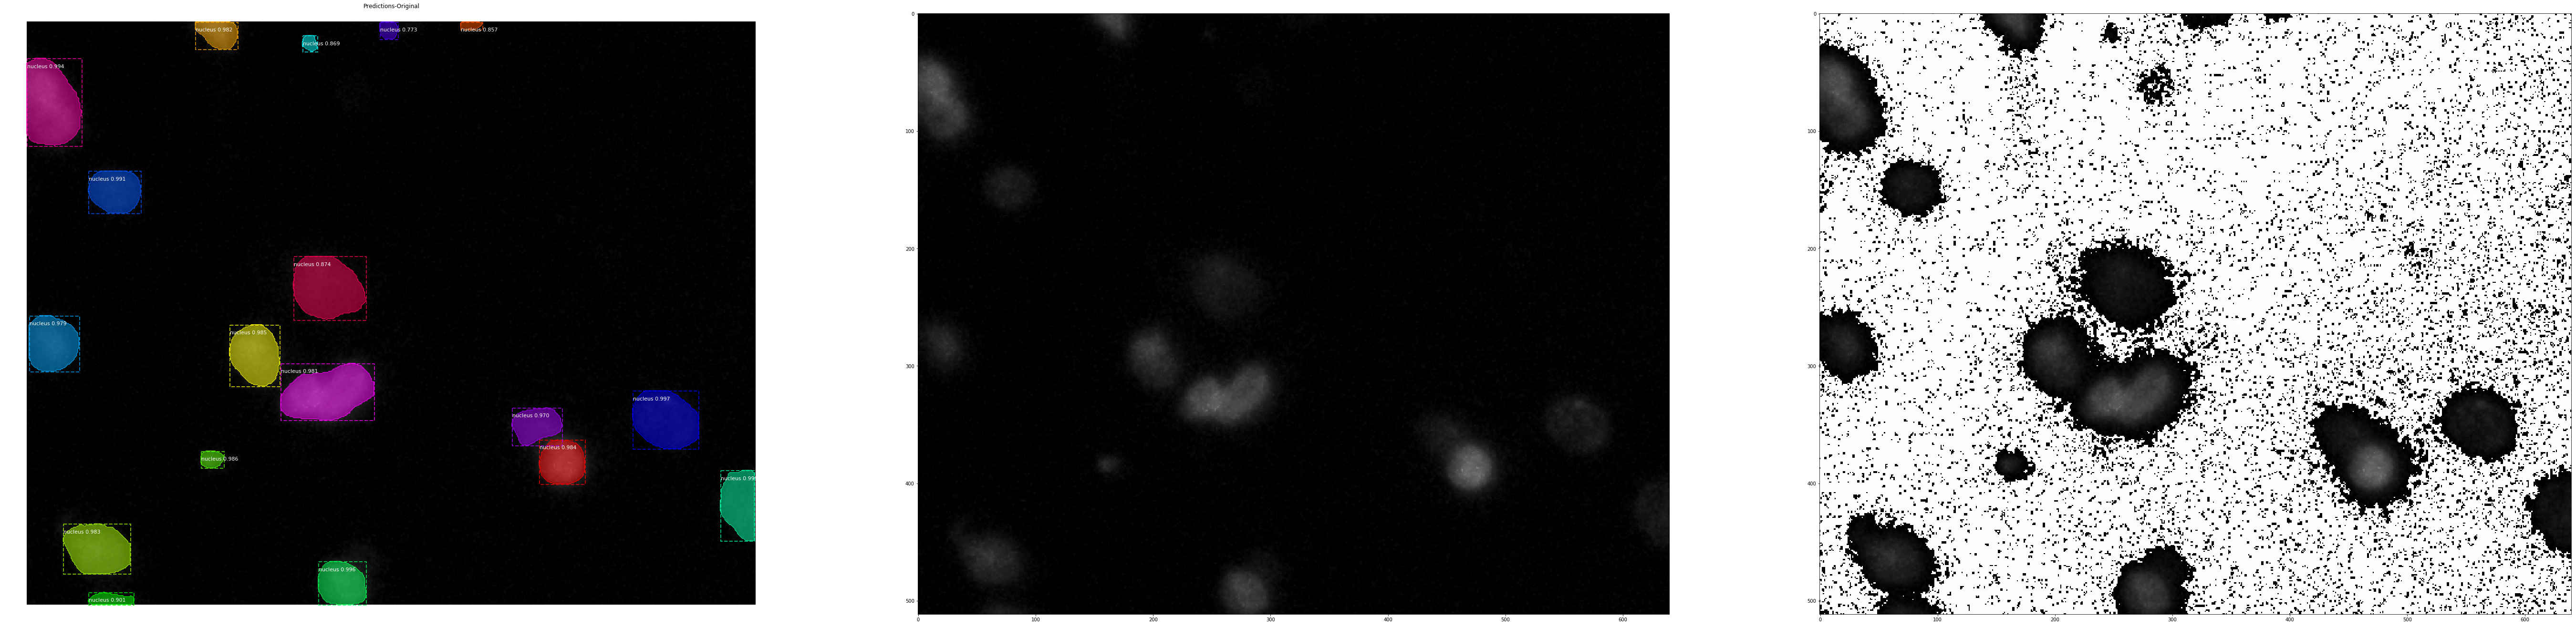

In [58]:

print(dataset_test.image_info[15]['path'])
ax=get_ax(1,3,size=32)
origimage1 = skimage.io.imread(dataset_test.image_info[15]['path'])
origimage=dataset_test.load_image(15)
#origimage=np.rot90(origimage)
#origimage1=np.rot90(origimage1)
ax[2].imshow(origimage.astype(np.uint8))
ax[1].imshow(origimage1.astype(np.uint8))
maskbbox=utils.extract_bboxes(masks_resized)
visualize.display_instances(origimage1, maskbbox, masks_resized, r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=ax[0],
                            title="Predictions-Original")
#visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                            dataset_test.class_names, r['scores'], ax=ax[1],
#                            title="Predictions-RCNN")

log("origimageimage",origimage1)
#ax = get_ax(1)


## Run Detection

In [ ]:
ax = get_ax(1)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

ax = get_ax(1)
visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names,  ax=ax,
                            title="Actual")
visualize.display_images([image],cols=1)

### Precision-Recall

In [ ]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

In [ ]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [ ]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 30)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [ ]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


In [ ]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [53]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 102300, 2)        min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 6000, 4)          min:  -45.25483  max:  638.82843
refined_anchors          shape: (1, 6000, 4)          min:  -13.70710  max:  657.46716
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:  640.00000
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 1738.00000
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


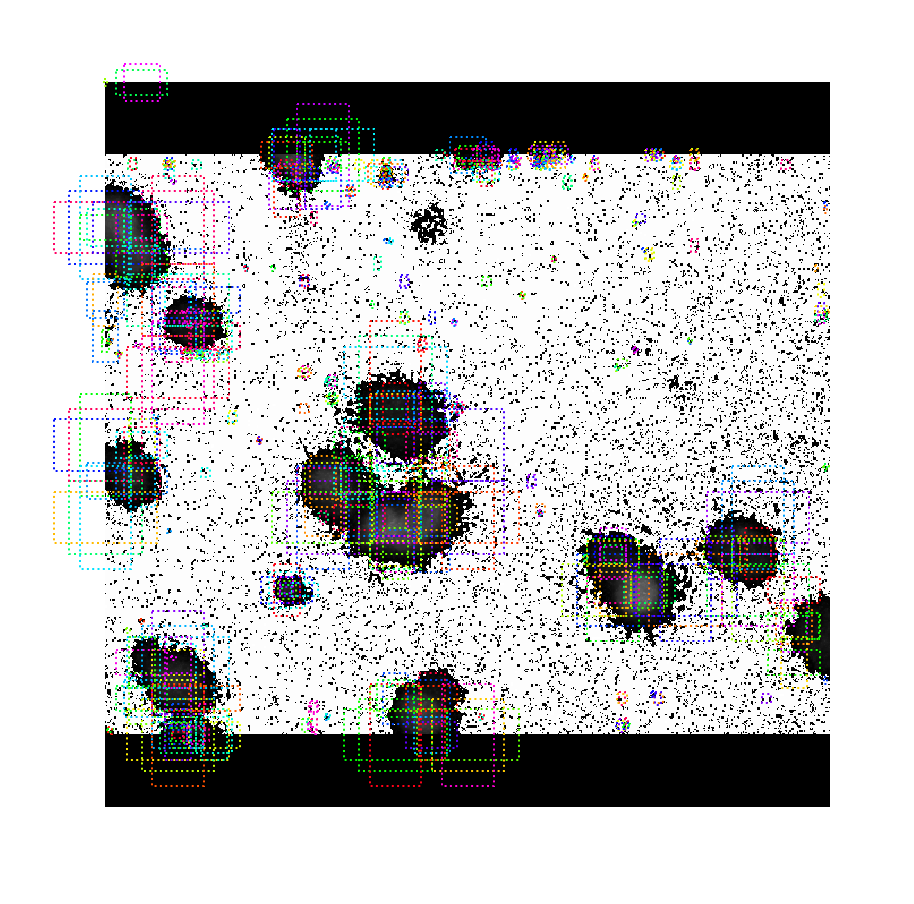

In [54]:
# Show top anchors by score (before refinement)
limit = 500
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

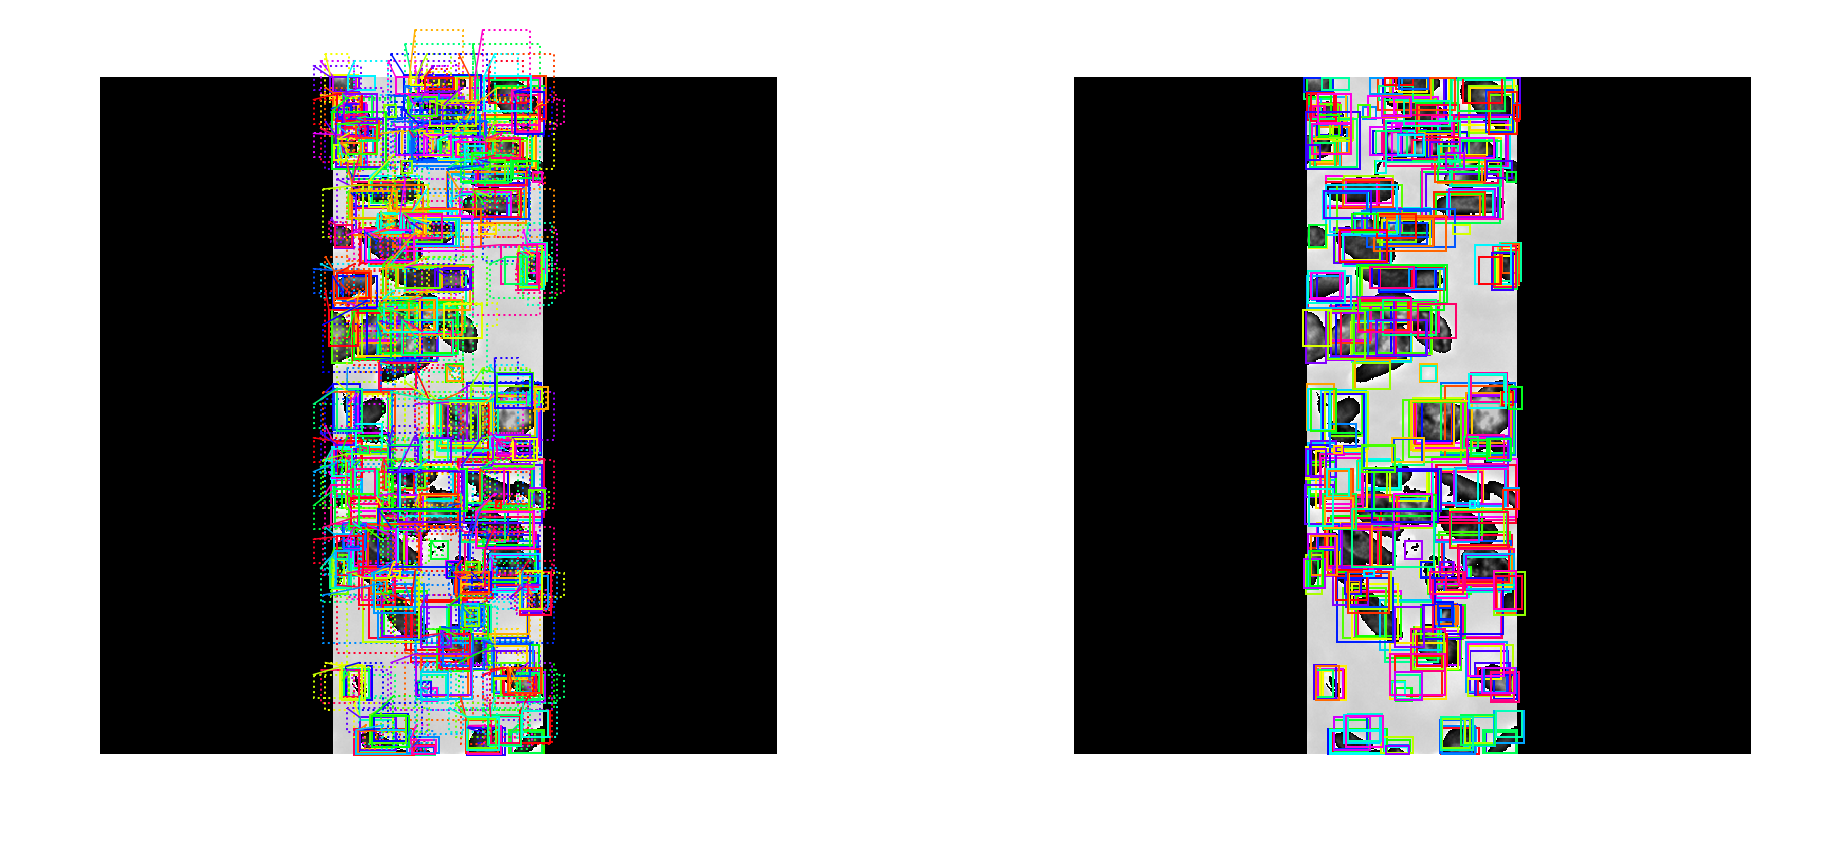

In [34]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 500
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

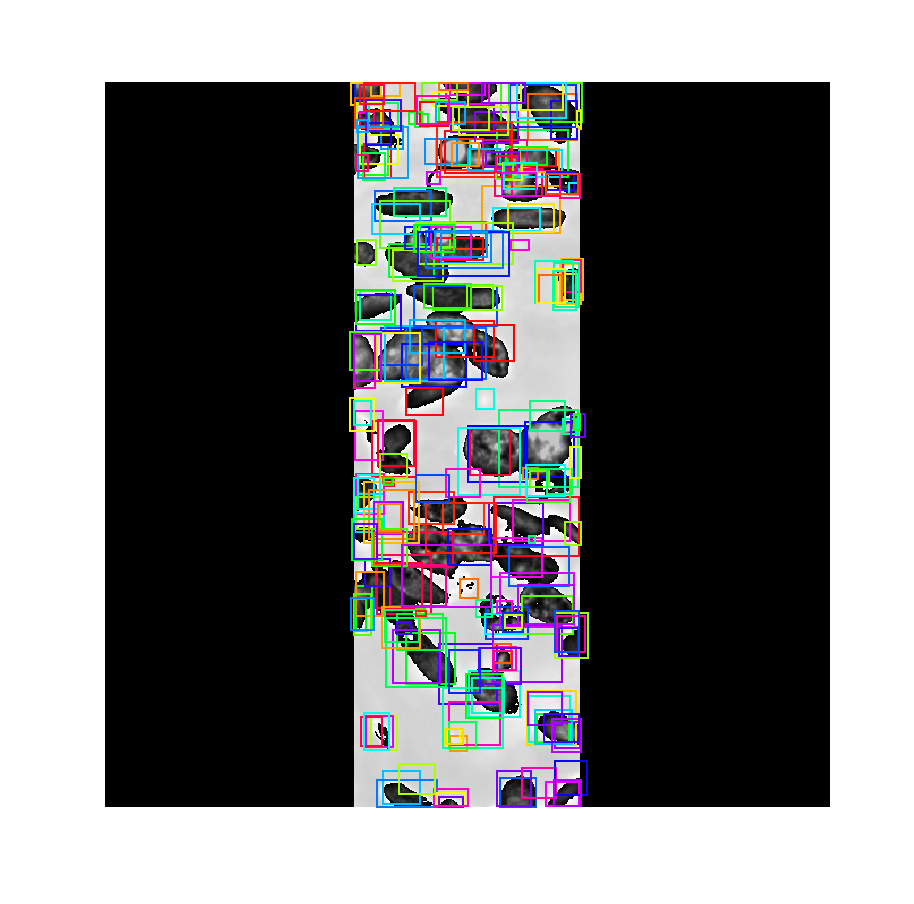

In [35]:
# Show refined anchors after non-max suppression
limit = 250
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

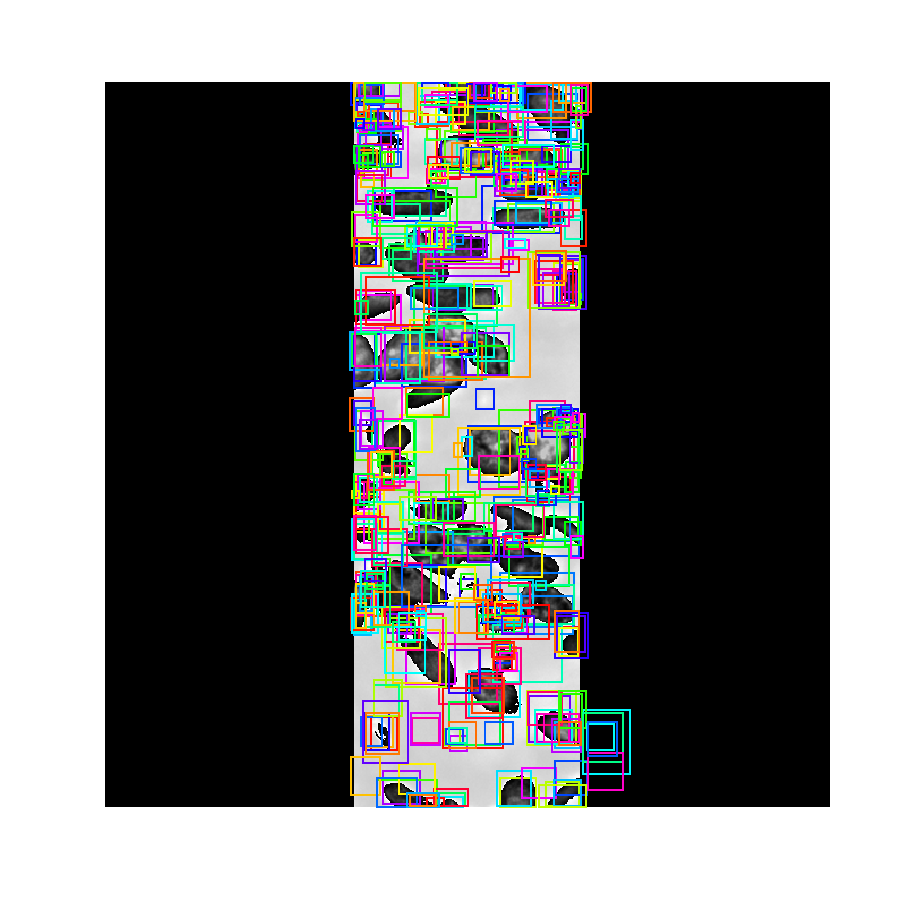

In [37]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 500
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [ ]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [38]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000
deltas                   shape: (1, 1000, 2, 4)       min:   -4.65772  max:    3.66084
masks                    shape: (1, 1000, 28, 28, 2)  min:    0.00000  max:    0.99997
detections               shape: (1, 1000, 6)          min:    0.00000  max:  640.00000


55 detections: ['nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus'
 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus'
 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus'
 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus'
 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus'
 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus'
 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus'
 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus']


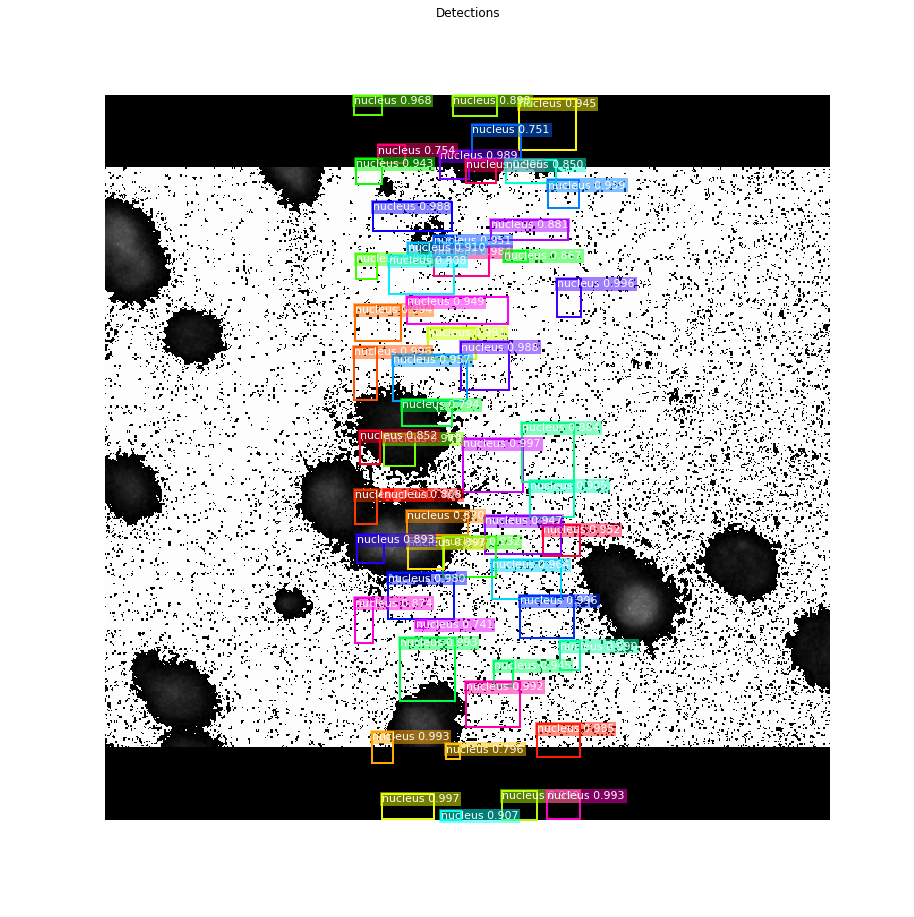

In [49]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_test.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset_test.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=detections[:, :4],
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [45]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset_test.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
211 Positive ROIs
[('BG', 789), ('nucleus', 211)]


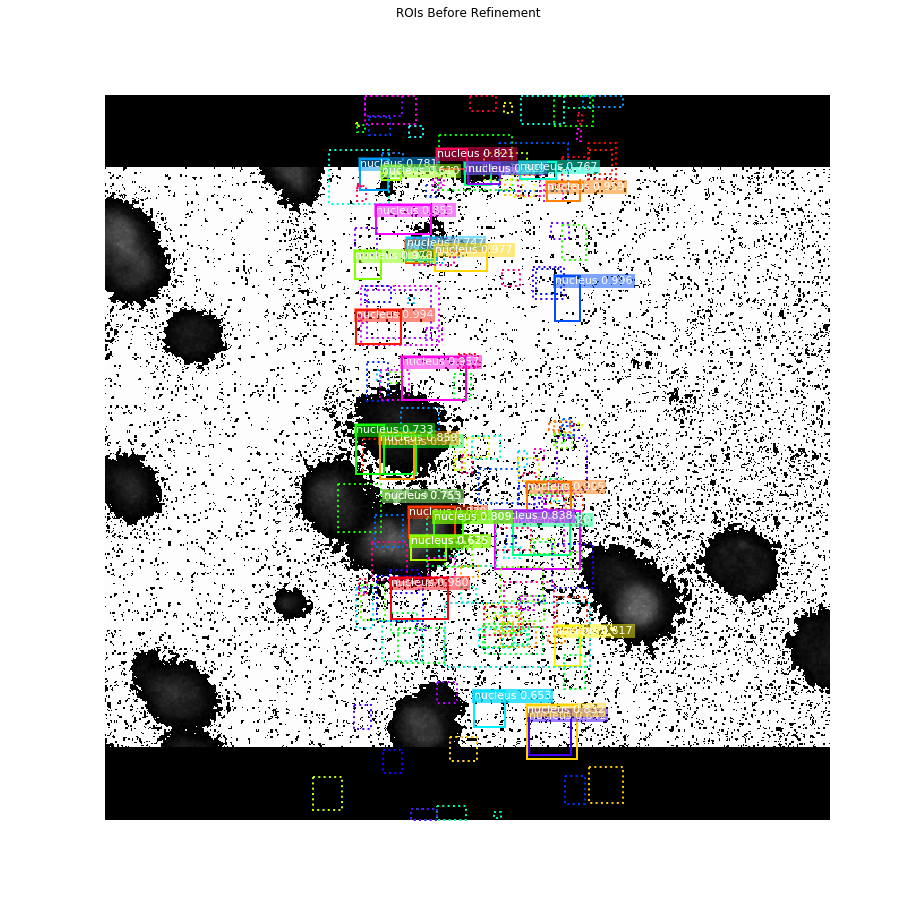

In [48]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset_test.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

In [ ]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

#### Per-Class Non-Max Suppression

In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

In [ ]:
# Masks
det_boxes = mrcnn["detections"][0, :, :4].astype(np.int32)
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

In [ ]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

In [ ]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

In [ ]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()